In [1]:
# Instalamos graphviz
!pip install graphviz


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from pandas import DataFrame

In [3]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')


## Funcions Auxiliars

In [4]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [5]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [6]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))


## Lectura del conjunt de dades


In [7]:
df = pd.read_csv('datasets/TotalFeatures-ISCXFlowMeter.csv')
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [9]:
df["calss"].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

## Busdquem correlacions

In [10]:
# Copiamos el conjunto de datos y transformamos la variable de salida a numérica para calcular correlaciones
X = df.copy()
X['calss'] = X['calss'].factorize()[0]

In [11]:
# Calculamos correlaciones
corr_matrix = X.corr()
corr_matrix["calss"].sort_values(ascending=False)

calss                     1.000000
flow_fin                  0.286175
min_seg_size_forward      0.258352
Init_Win_bytes_forward    0.129425
std_fpktl                 0.123758
                            ...   
furg_cnt                       NaN
burg_cnt                       NaN
flow_urg                       NaN
flow_cwr                       NaN
flow_ece                       NaN
Name: calss, Length: 80, dtype: float64

In [12]:
X.corr()


,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
total_fpackets,0.004837,1.000000,0.924622,0.425756,0.904007,-0.018958,0.005252,0.024685,0.086255,-0.007910,...,0.001614,0.002267,0.017229,0.016089,0.050201,0.059224,0.902713,0.999866,0.018198,0.018377
total_bpackets,0.004011,0.924622,1.000000,0.156780,0.997268,-0.017667,0.006912,0.018170,0.086886,-0.016104,...,0.000922,0.001617,0.016230,-0.000493,0.048190,0.058435,0.997580,0.924746,0.015124,0.019430
total_fpktl,0.001673,0.425756,0.156780,1.000000,0.090082,-0.003099,0.000803,0.021278,0.022088,0.022409,...,0.000335,0.000609,0.009896,0.001657,0.013283,0.015991,0.088422,0.425789,0.005477,0.000679
total_bpktl,0.003518,0.904007,0.997268,0.090082,1.000000,-0.014926,0.005966,0.012560,0.079905,-0.017328,...,0.000812,0.001452,0.014336,-0.000293,0.043571,0.053134,0.999616,0.904129,0.012139,0.019838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.029712,0.059224,0.058435,0.015991,0.053134,-0.268444,0.038319,0.429893,0.593143,-0.030004,...,0.026959,0.029512,0.097316,-0.052507,0.811204,1.000000,0.056761,0.059242,0.333701,0.069405
RRT_samples_clnt,0.003785,0.902713,0.997580,0.088422,0.999616,-0.016659,0.006156,0.015727,0.084280,-0.017595,...,0.000893,0.001560,0.015200,-0.000437,0.046784,0.056761,1.000000,0.902834,0.014299,0.019679
Act_data_pkt_forward,0.004838,0.999866,0.924746,0.425789,0.904129,-0.018947,0.005264,0.024705,0.086278,-0.007893,...,0.001617,0.002269,0.017233,0.000734,0.050220,0.059242,0.902834,1.000000,0.018229,0.018391
min_seg_size_forward,0.082955,0.018198,0.015124,0.005477,0.012139,-0.686154,-0.189824,-0.074763,0.217989,-0.524024,...,0.077943,0.079324,0.048803,0.052177,0.394743,0.333701,0.014299,0.018229,1.000000,0.258352


In [13]:
# Se puede llegar a valorar quedarnos con aquellas que tienen mayor correlación
corr_matrix[corr_matrix["calss"] > 0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
max_bpktl,0.042925,0.086255,0.086886,0.022088,0.079905,-0.277317,0.275923,0.492194,1.000000,-0.018358,...,0.035413,0.038732,0.127548,-0.044916,0.586742,0.593143,0.084280,0.086278,0.217989,0.073212
mean_bpktl,0.025117,0.139142,0.151761,0.018954,0.146437,-0.280648,0.465208,0.342392,0.895712,-0.096195,...,0.018533,0.021519,0.114949,-0.045442,0.452735,0.478823,0.150252,0.139172,0.122226,0.064753
std_fpktl,0.039350,0.010172,0.002331,0.011416,-0.003162,-0.245792,0.052877,0.817873,0.564243,0.259588,...,0.031418,0.033978,0.096844,-0.020885,0.558249,0.532900,0.000140,0.010182,0.301237,0.123758
std_bpktl,0.048743,0.020324,0.014005,0.007763,0.007768,-0.225143,0.035371,0.534532,0.941626,0.051756,...,0.042562,0.045450,0.113854,-0.033991,0.594790,0.577954,0.012050,0.020335,0.276055,0.072953
total_fiat,0.943898,0.002190,0.001718,0.000708,0.001546,-0.049879,-0.031218,-0.029233,-0.005961,-0.048869,...,0.943668,0.943339,0.015254,0.020302,-0.011637,-0.016421,0.001615,0.002190,0.065124,0.064770
min_fiat,0.841692,-0.001975,-0.002172,-0.000746,-0.001820,-0.040046,-0.036619,-0.052289,-0.035963,-0.053811,...,0.843330,0.842512,-0.005389,0.015316,-0.027350,-0.033944,-0.002037,-0.001974,0.051853,0.074491
max_fiat,0.943438,-0.000420,-0.000714,-0.000389,-0.000548,-0.046977,-0.032630,-0.032606,-0.009878,-0.049032,...,0.944412,0.943971,0.012557,0.017756,-0.012317,-0.016206,-0.000644,-0.000418,0.061285,0.064875
mean_fiat,0.918036,-0.001970,-0.002241,-0.000728,-0.001907,-0.042455,-0.036056,-0.048712,-0.032412,-0.052892,...,0.919653,0.918797,-0.003523,0.016958,-0.025823,-0.032466,-0.002113,-0.001968,0.055151,0.071397
std_flowpktl,0.036942,0.087741,0.087307,0.024298,0.080666,-0.262968,0.338513,0.631466,0.911584,0.095976,...,0.030013,0.033100,0.120257,-0.035737,0.580266,0.586355,0.084725,0.087764,0.219346,0.119375


## Dividim el conjunt de dades

In [32]:

# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(X)

In [33]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

## Escalem les dades

In [34]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [35]:
X_test_scaled = scaler.transform(X_test)


In [36]:
X_val_scaled = scaler.transform(X_val)


In [37]:
# Transformación a un DataFrame de Pandas
X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
508881,-0.013646,0.0,1.0,-0.310056,1.556886,0.375000,4.924528,-0.027100,2.250000,-0.032895,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
208326,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
107213,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
466726,-0.000273,0.0,1.0,-0.363128,2.724551,0.035714,8.603774,-0.078591,3.931034,-0.095395,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
230085,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
472961,34.421927,1.5,4.0,1.558659,3.868263,0.000000,1.000000,1.341463,4.163793,0.337171,...,59.657102,48.116772,47.580946,0.0,0.0,13.421042,12.657580,3.0,1.5,0.0
482372,-0.013805,0.5,0.0,-0.136872,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050987,...,0.000000,0.000000,0.000000,0.0,1.0,-0.080736,0.000000,0.0,0.5,0.0
619993,17.578734,0.5,0.0,-0.050279,0.000000,0.553571,0.000000,0.000000,0.000000,0.000000,...,30.549478,24.617883,24.365465,0.0,1.0,0.063376,0.000000,0.0,0.5,0.0
65344,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
46666,-0.013926,0.0,0.0,0.505587,0.000000,5.589286,0.000000,0.764228,0.000000,0.927632,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0


In [38]:
X_train_scaled.describe()


,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,...,379173.000000,379173.000000,379173.000000,3.791730e+05,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000
mean,12.543409,2.927643,10.762678,1.947184,75.104138,1.600682,0.855241,0.491724,1.591823,0.303639,...,19.838596,16.279309,16.441899,4.686618e+05,0.362658,2.861506,3.435883,10.087709,2.924548,-0.376798
std,116.165117,92.319402,370.875546,185.549801,3071.968461,2.817301,1.676098,0.786500,3.210186,0.533388,...,201.477623,162.562856,160.822696,6.188642e+06,3.836035,5.577212,7.354164,369.660712,92.301146,0.466297
min,-0.013936,-0.500000,0.000000,-0.513966,0.000000,-0.946429,0.000000,-0.227642,0.000000,-0.273026,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286345,0.000000,0.000000,-0.500000,-1.000000
25%,-0.013926,0.000000,0.000000,-0.321229,0.000000,0.000000,0.000000,-0.084011,0.000000,-0.101974,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286342,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.986074,1.000000,1.000000,0.678771,1.000000,1.000000,1.000000,0.915989,1.000000,0.898026,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.713658,1.000000,1.000000,1.000000,0.000000
max,25277.128872,24127.000000,74768.000000,113118.041899,622288.473054,23.892857,26.245283,3.840108,11.991379,4.299342,...,43893.471528,35408.189283,35008.286082,5.670000e+08,2267.000000,13.421042,46.346741,74524.000000,24127.000000,0.375000


## Arbre de decissió

In [21]:
from sklearn.tree import DecisionTreeClassifier

MAX_DEPTH = 20

# Modelo entrenado con el conjunto de datos sin escalar
clf_tree = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [22]:
# Modelo entrenado con el conjunto de datos escalado
clf_tree_scaled = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=42)
clf_tree_scaled.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [23]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train)
y_train_prep_pred = clf_tree_scaled.predict(X_train_scaled)

In [24]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 0.9593915432471419
f1_score WITH preparation: 0.9593876451031004


In [25]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_tree.predict(X_val)
y_prep_pred = clf_tree_scaled.predict(X_val_scaled)

In [26]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9335628011437564
f1_score WITH preparation: 0.9335467321600617


## Visualització

In [27]:
# Reducimos el número de atributos del conjunto de datos para visualizarlo mejor
X_train_reduced = X_train[['min_flowpktl', 'flow_fin']]

In [28]:
# Generamos un modelo con el conjunto de datos reducido
clf_tree_reduced = DecisionTreeClassifier(max_depth=2, random_state=42)
clf_tree_reduced.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

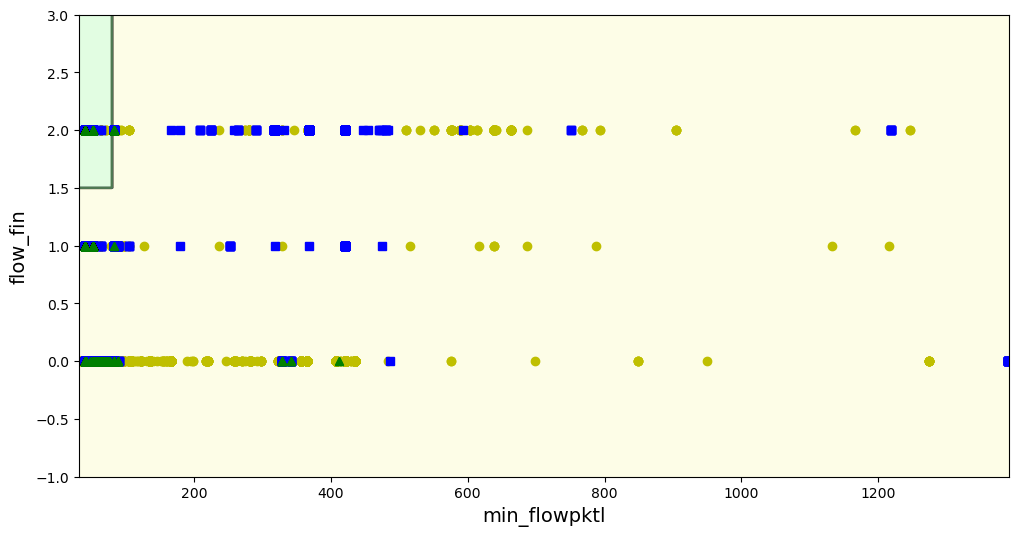

In [29]:
# Representamos gráficamente el límite de decisión construido
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_boundary(clf, X, y, plot_training=True, resolution=1000):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="normal")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="adware")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="malware")
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])               
    plt.xlabel('min_flowpktl', fontsize=14)
    plt.ylabel('flow_fin', fontsize=14, rotation=90)

plt.figure(figsize=(12, 6))
plot_decision_boundary(clf_tree_reduced, X_train_reduced.values, y_train)
plt.show()

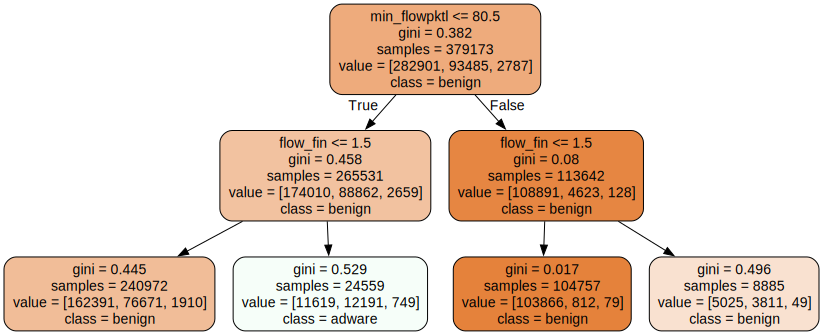

In [39]:
# Pintamos el árbol para compararlo con la representación gráfica anterior
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        clf_tree_reduced,
        out_file="android_malware.dot",
        feature_names=X_train_reduced.columns,
        class_names=["benign", "adware", "malware"],
        rounded=True,
        filled=True
    )

Source.from_file("android_malware.dot")